In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, expr, percentile_approx
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import os

# Start Spark session
spark = SparkSession.builder \
    .appName("OPSData") \
    .getOrCreate()

# Optional: reduce log noise
spark.sparkContext.setLogLevel("WARN")


In [2]:
base_path = os.path.expanduser("~/Documents/SparkNotebooks/opsd")
file_name = "time_series_60min_singleindex.csv"

file_path = os.path.join(base_path, file_name)

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Dataset is really wide and can't be viewed properly in notebooks
df.show(5)


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [3]:
df.printSchema()         # See all the columns and data types

root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [4]:
df.columns               # Get list of column names

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [5]:
df.select("utc_timestamp", "IE_load_actual_entsoe_transparency").show(10)

+-------------------+----------------------------------+
|      utc_timestamp|IE_load_actual_entsoe_transparency|
+-------------------+----------------------------------+
|2015-01-01 01:00:00|                              NULL|
|2015-01-01 02:00:00|                            2832.0|
|2015-01-01 03:00:00|                            2678.0|
|2015-01-01 04:00:00|                            2432.0|
|2015-01-01 05:00:00|                            2276.0|
|2015-01-01 06:00:00|                            2173.0|
|2015-01-01 07:00:00|                            2136.0|
|2015-01-01 08:00:00|                            2166.0|
|2015-01-01 09:00:00|                            2215.0|
|2015-01-01 10:00:00|                            2237.0|
+-------------------+----------------------------------+
only showing top 10 rows



In [6]:
# Count rows
df.count()

50401

In [7]:
# Basic stats on a numeric column
df.describe("IE_load_actual_entsoe_transparency").show()

+-------+----------------------------------+
|summary|IE_load_actual_entsoe_transparency|
+-------+----------------------------------+
|  count|                             49837|
|   mean|                3191.2216425547285|
| stddev|                 608.6479345942973|
|    min|                            1790.0|
|    max|                            5018.0|
+-------+----------------------------------+



In [8]:
# Get null counts
nulls = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Convert to Pandas and sort by null count
nulls_pd = nulls.toPandas().T
nulls_pd.columns = ['null_count']
nulls_pd = nulls_pd.sort_values(by='null_count', ascending=False)

# Show top 20 columns with most nulls
nulls_pd.head(20)


,null_count
HR_solar_generation_actual,50391
HR_wind_onshore_generation_actual,50379
PT_wind_offshore_generation_actual,47509
PT_wind_generation_actual,47509
PL_solar_generation_actual,46237
HU_solar_generation_actual,41436
SK_wind_onshore_generation_actual,40722
NO_5_wind_onshore_generation_actual,40132
NO_1_wind_onshore_generation_actual,35815
DE_LU_load_forecast_entsoe_transparency,33745


In [9]:
# Function to compute median for a column
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Fill nulls with median (for numeric columns only)
# Grab a BIG cup of coffee this is going to take a while with the 60min-csv (3-5 mins)
for c in df.columns:
    try:
        median_val = get_median(df.filter(col(c).isNotNull()), c)
        df = df.fillna({c: median_val})
    except:
        print(f"Skipping non-numeric or problematic column: {c}")


Skipping non-numeric or problematic column: utc_timestamp
Skipping non-numeric or problematic column: cet_cest_timestamp


In [10]:
df = df.withColumn("date", to_date("utc_timestamp"))

In [11]:
# Create a list of columns to average (skip timestamps and 'date')
cols_to_avg = [c for c in df.columns if c not in ["utc_timestamp", "cet_cest_timestamp", "date"]]

# Group and aggregate
daily_avg_df = df.groupBy("date").agg(
    *[avg(c).alias(f"{c}_daily_avg") for c in cols_to_avg]
)


In [12]:
# Again too wide to show properly
# The data itself should be fine though
daily_avg_df.show(10)

+----------+--------------------------------------------+----------------------------------------------+----------------------------+------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+------------------------------------+-----------------------------------+--------------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+------------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+---------------------------+------------------------------------+----------------------------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+-------------------------------

In [13]:
daily_avg_df.select("date", "ie_sem_price_day_ahead_daily_avg", "ie_sem_wind_onshore_generation_actual_daily_avg").show(10)

+----------+--------------------------------+-----------------------------------------------+
|      date|ie_sem_price_day_ahead_daily_avg|ie_sem_wind_onshore_generation_actual_daily_avg|
+----------+--------------------------------+-----------------------------------------------+
|2015-03-09|               43.07000000000002|                                        1621.25|
|2015-05-19|               43.07000000000002|                             1639.0416666666667|
|2015-03-06|               43.07000000000002|                             1947.0416666666667|
|2015-04-09|               43.07000000000002|                              331.0833333333333|
|2015-05-10|               43.07000000000002|                             1720.2083333333333|
|2015-03-12|               43.07000000000002|                                        1373.75|
|2015-03-16|               43.07000000000002|                                          287.0|
|2015-04-01|               43.07000000000002|               

In [14]:
# PDF = Pandas Data Frame
# Change/add to these as needed

pdf = daily_avg_df.select("date", "ie_sem_price_day_ahead_daily_avg", "ie_sem_wind_onshore_generation_actual_daily_avg").orderBy("date").toPandas()

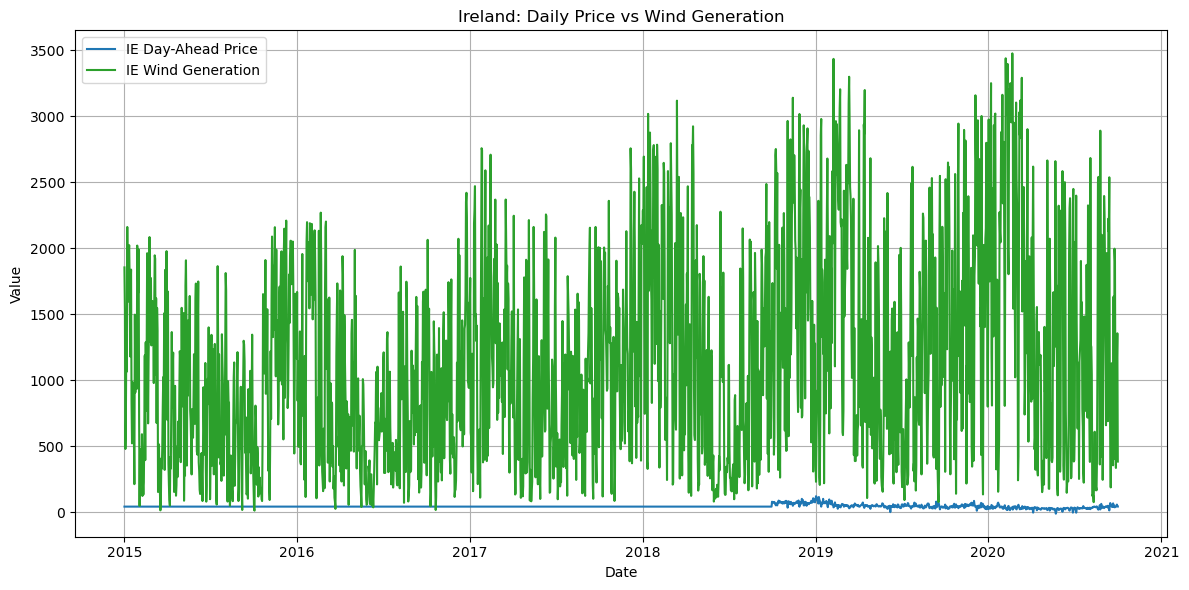

In [15]:
# An example plot
plt.figure(figsize=(12, 6))

# Play around with these and figure out some meaningful comparisons
# First axis
plt.plot(pdf["date"], pdf["ie_sem_price_day_ahead_daily_avg"], label="IE Day-Ahead Price", color="tab:blue")

# Second axis
plt.plot(pdf["date"], pdf["ie_sem_wind_onshore_generation_actual_daily_avg"], label="IE Wind Generation", color="tab:green")

plt.title("Ireland: Daily Price vs Wind Generation")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()